## Classificação de espécies de Pinguins

O objetivo é classificar as diversas espécies de pinguins com base em seus atributos distintivos. O conjunto de dados à nossa disposição compreende uma série de variáveis preditoras e alvos que utilizaremos para a tarefa de classificação.

Preditores:
* Culmen Length (mm)
* Culmen Depth (mm)
* Flipper Length (mm)
* Body Mass (g)

Alvo - Espécie:
* Adelie
* Chinstrap
* Gentoo

Data Origin:
Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



### Carga do dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/lucas-sloureiro/MVP3_PUC-Rio/main/penguins_size.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Análise exploratória e limpeza dos dados

In [3]:
# checa valores nulos
dataset.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

A quantidade de valores ausentes é desprezível e não afeta o resultado final, portanto eles serão removidos para limpar a base.

In [4]:
# dropa nulos
dataset = dataset.dropna()

In [5]:
# checa valores duplicados
dataset.duplicated().sum()

0

In [6]:
# dropa features extras
dataset = dataset.drop(['island', 'sex'], axis=1)

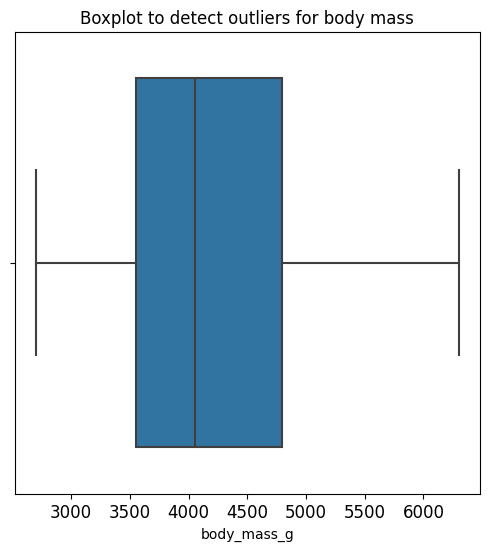

In [7]:
# checa outliers de massa corporal
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for body mass', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=dataset['body_mass_g'])
plt.show()

Os dados não apresentam pontos fora da curva que demandem correção.


In [8]:
# Checagem do percentual de registros de cada espécie
# Esta etapa é importante para verificar se temos registros suficientes para a classificação multi-label
print(dataset['species'].value_counts())
print()

# Get percentages of each species
print(dataset['species'].value_counts(normalize=True))

Adelie       146
Gentoo       120
Chinstrap     68
Name: species, dtype: int64

Adelie       0.437126
Gentoo       0.359281
Chinstrap    0.203593
Name: species, dtype: float64


Aviso: as espécies Adelie e Gentoo são mais numerosas do que a Chinstrap, mas temos dados suficientes de cada espécie para continuar com a modelagem.

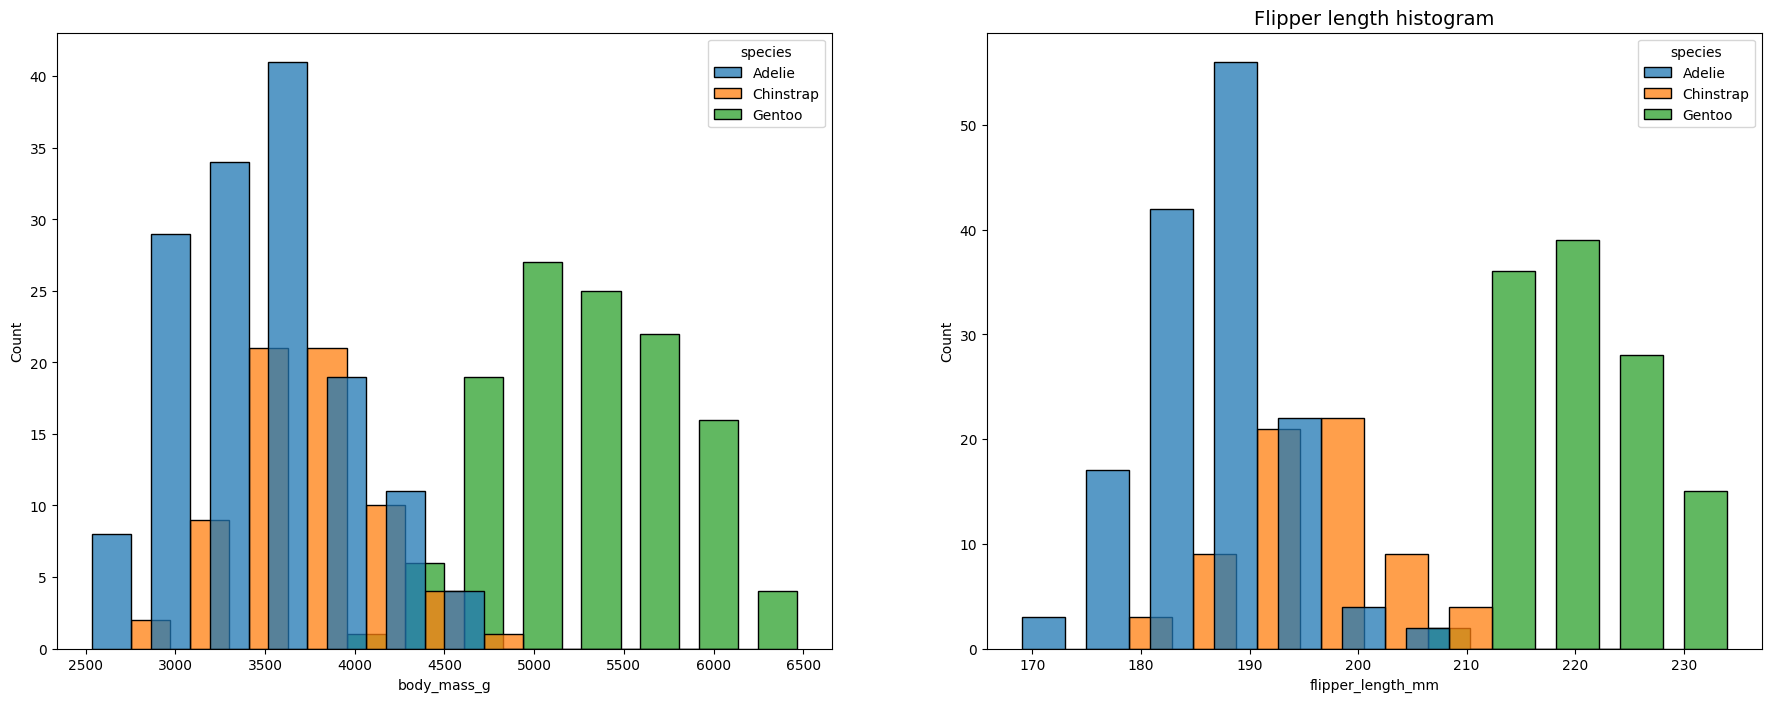

In [11]:
# Configura os plots para checagem de distribuição de massa corporal de cada espécie
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Cria histograma da distribuição de 'body_mass_g' para cada espécie
adelie = dataset[dataset['species']=='Adelie']['body_mass_g']
gentoo = dataset[dataset['species']=='Gentoo']['body_mass_g']
chinstrap = dataset[dataset['species']=='Chinstrap']['body_mass_g']
sns.histplot(data=dataset, x='body_mass_g', hue='species', multiple='dodge', shrink=2, ax=ax[0])
ax[1].set_title('Body mass histogram', fontsize='14')

# Cria histograma com a distribuição de `flipper_length_mm` para cada espécie
adelie = dataset[dataset['species']=='Adelie']['flipper_length_mm']
gentoo = dataset[dataset['species']=='Gentoo']['flipper_length_mm']
chinstrap = dataset[dataset['species']=='Chinstrap']['flipper_length_mm']
sns.histplot(data=dataset, x='flipper_length_mm', hue='species', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Flipper length histogram', fontsize='14')


# Display
plt.show()

* A média de massa corporal dos pinguins Gentoo é de cerca de 5 kg.
Isso é maior do que as médias dos pinguins Adelie (3,6 kg) e Chinstrap (3,4 kg).

* A distribuição de massa corporal dos pinguins Gentoo é mais concentrada em torno da média. Isso significa que há menos variação na massa corporal dos pinguins Gentoo do que nas outras espécies.

* A massa corporal dos pinguins Gentoo não parece ser afetada pelo sexo.

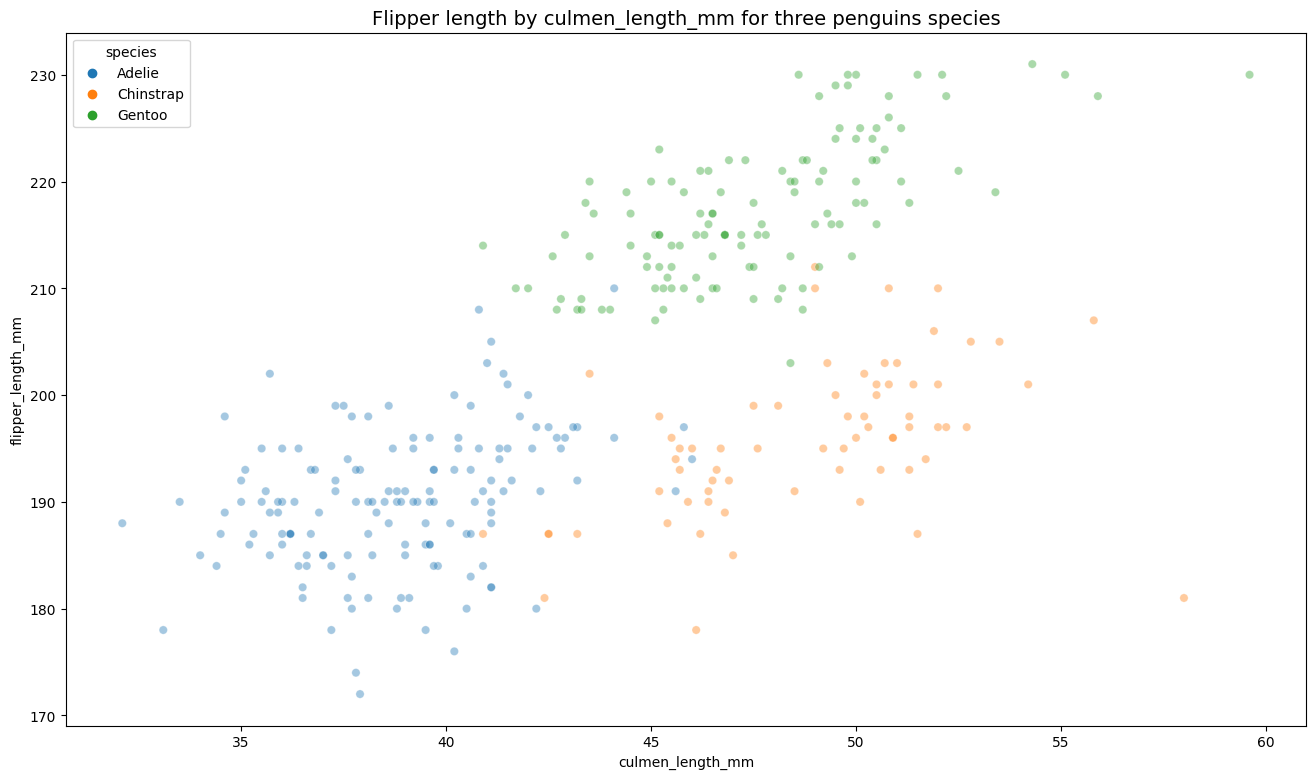

In [12]:
# Cria gráfico de dispersão de `flipper_length_mm` by e `culmen_length_mm` por espécie
plt.figure(figsize=(16, 9))
sns.scatterplot(data=dataset, x='culmen_length_mm', y='flipper_length_mm', hue='species', alpha=0.4)
plt.title('Flipper length by culmen_length_mm for three penguins species', fontsize='14');

Este gráfico confirma os histogramas anteriores e sugere que os pinguins Gentoo são maiores, em média, do que os pinguins Adélie e Chinstrap.

### Separação dos dados em treino e teste

In [13]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,1:5]
y = array[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Modelagem

KNN: 0.782906 (0.042498)
CART: 0.966382 (0.038976)
NB: 0.970228 (0.022274)
SVM: 0.741595 (0.042807)


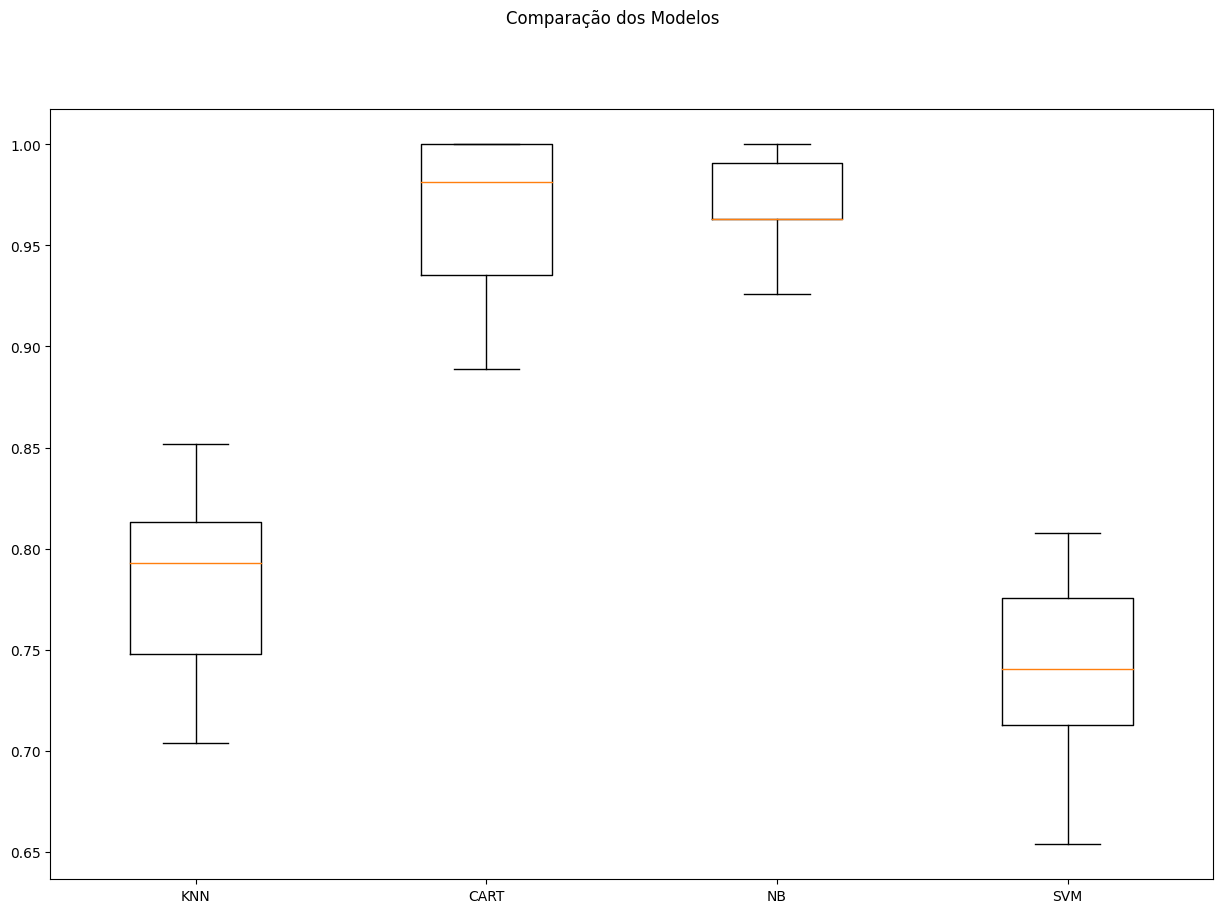

In [14]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

O modelo que teve a melhor performance com os dados brutos foi o Naive Bayes. Fizemos um teste de avaliação dos modelos usando dados normalizados e padronizados para comparar os resultados.

### Avaliação dos modelos: dados normalizados e padronizados

KNN-orig: 0.783 (0.042)
CART-orig: 0.966 (0.039)
NB-orig: 0.970 (0.022)
SVM-orig: 0.742 (0.043)
KNN-padr: 0.989 (0.017)
CART-padr: 0.977 (0.030)
NB-padr: 0.970 (0.022)
SVM-padr: 0.985 (0.018)
KNN-norm: 0.989 (0.017)
CART-norm: 0.966 (0.039)
NB-norm: 0.970 (0.022)
SVM-norm: 0.985 (0.018)


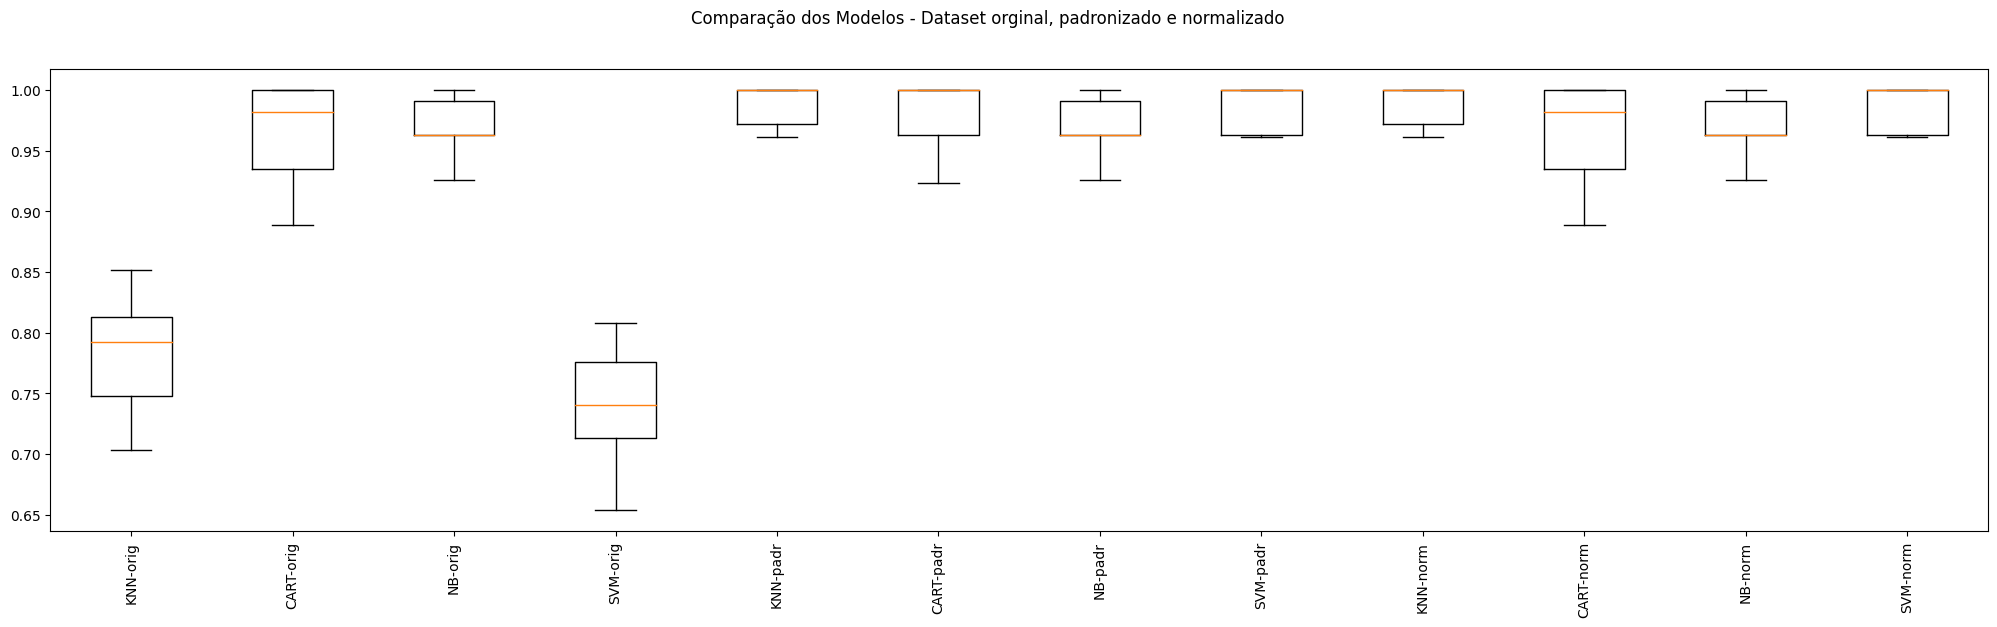

In [15]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

O modelo KNN normalizado teve a maior acurácia de todos, logo foi selecionado para implementação. O modelo passa para o estágio de otimização de hiperparâmetros para elevar ainda mais a performance e realizar possíveis ‘ajustes’ para atingirmos a melhor predição possível.

### Otimização de hiperparâmetros

In [16]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.868661 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
Sem tratamento de missings: knn-padr - Melhor: 0.988746 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-norm - Melhor: 0.988746 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}


O número ideal de neighbors identificado é 3 ou 5 e a melhor métrica para ser utilizada é 'euclidean'. Tais hiperparâmetros serão aplicados abaixo.

### Finalização do modelo

In [17]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='euclidean', n_neighbors=3)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9850746268656716


In [18]:
# Preparação do modelo com o dataset completo
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Simulação: aplicação do modelo em dados não vistos

Simulação de um pipeline de produção para avaliar o comportamento do modelo deployado.

In [19]:
dataset.tail()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0
343,Gentoo,49.9,16.1,213.0,5400.0


In [20]:
# Novos dados que não sabemos a espécie
data = {'culmen_length_mm':  [53.5, 49.8, 39.2],
        'culmen_depth_mm': [19.9, 14, 17.9],
        'flipper_length_mm': [205, 211.0, 187.0],
        'body_mass_g': [4500, 5100.0, 3650.0],
        }

atributos = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 1.74341421  1.39418572  0.28462125  0.36203598]
 [ 1.0648066  -1.60841798  0.71315692  1.10864787]
 [-0.87931247  0.37635396 -1.00098577 -0.6956642 ]]


In [21]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

['Chinstrap' 'Gentoo' 'Adelie']


### Salva modelo treinado

In [22]:
# export do modelo em pickle file
pickle_out = open('classificador.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()

### Sobre o modelo K-Nearest Neighbors (KNN):

K-Nearest Neighbors (KNN) é um algoritmo de aprendizado de máquina que se baseia no princípio de que pontos de dados semelhantes tendem a estar próximos no espaço de características. Ele é usado para classificação e regressão, onde a ideia-chave é que objetos com características semelhantes compartilham a mesma classe ou categoria.

### Penguin Classifier

*   Modelo utilizado: KNN
*   Técnicas aplicadas: normalização e padronização
*   Medida de similaridade: euclidiana
*   Número de vizinhos: 3
*   Métrica de Avaliação: acurácia
*   Performance alcançada com a métrica de avaliação: 0.98507 (98%)
*   Casos de uso/limitações: modelo dependente dos dados de entrada. Se alguma das espécies tiver dados de entrada muito reduzido, há a possibilidade de afetar o re-treino do modelo e prejudicar a classificação.